Let's load the data now.

In [131]:
import pandas as pd 
import numpy as np 
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC # "Support vector classifier"  
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


netflix_data=pd.read_excel('netflix.xlsx')
netflix_data.head()

,title,rating,ratingLevel,ratingDescription,release year,user rating score,user rating size
0,White Chicks,PG-13,"crude and sexual humor, language and some drug...",80,2004,82.0,80
1,Lucky Number Slevin,R,"strong violence, sexual content and adult lang...",100,2006,NaN,82
2,Grey's Anatomy,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,98.0,80
3,Prison Break,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2008,98.0,80
4,How I Met Your Mother,TV-PG,Parental guidance suggested. May not be suitab...,70,2014,94.0,80


In [132]:
netflix_data=netflix_data.dropna()

In [133]:
rate=list(netflix_data['user rating score'])
ratee=[]
for i in rate:
    i=int(i)
    if i <= 40:
        ratee.append(0)
    elif i> 40 and i <70:
        ratee.append(1)
    else:
        ratee.append(2)
netflix_data['class']=ratee
netflix_data.head()

,title,rating,ratingLevel,ratingDescription,release year,user rating score,user rating size,class
0,White Chicks,PG-13,"crude and sexual humor, language and some drug...",80,2004,82.0,80,2
2,Grey's Anatomy,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,98.0,80,2
3,Prison Break,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2008,98.0,80,2
4,How I Met Your Mother,TV-PG,Parental guidance suggested. May not be suitab...,70,2014,94.0,80,2
5,Supernatural,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,95.0,80,2


In [135]:
value_C= netflix_data['user rating score'].mean()
value_C

84.04355400696865

On a scale from 1 to 100, the overall average rating for all of the films is approximately a 60. The following step is to ascertain a suitable value for m, which stands for the minimum number of votes necessary to be included in the chart. As our threshold, we shall utilise the 90th percentile. To put it another way, in order for a film to make it into the rankings, it must have received a greater number of votes than at least ninety percent of the other films on the list.

In [136]:
movie= netflix_data['user rating size'].quantile(0.9)
movie

80.0

Now that we have this information, we can select only those movies that are eligible for the chart.

In [137]:
query_movies = netflix_data.copy().loc[netflix_data['user rating size'] >= movie]
query_movies.shape

(574, 8)

It has come to our attention that a total of 481 films meet the requirements to be included on this list. Now that we have all of the qualified movies, we need to calculate our measure for each one. In order to accomplish this, we will first define a function called weighted rating() and then define a new feature called score. For the score feature, we will calculate its value by applying weighted rating() to our DataFrame containing qualified movies as follows:

In [138]:
def weightedrating1(data, m=movie, C=value_C):
    vote = data['user rating size']
    Rating = data['user rating score']
    # Calculation based on the IMDB formula
    return (vote/(vote+m) * Rating) + (m/(m+vote) * C)

In [139]:
# Define a new feature to be called "score," and determine its value by calling the function "weighted rating()."
query_movies['score'] = query_movies.apply(weightedrating1, axis=1)

Last but not least, let's sort the DataFrame according to the score feature, and then output the title, vote count, vote average, and weighted rating or score of the top 10 movies.

In [140]:
#Sort movies in accordance with the score determined up top.
query_movies = query_movies.sort_values('score', ascending=False)

#Produce a list of the top 15 films.
query_movies[['title','user rating score','user rating size','score']].head(10)

,title,user rating score,user rating size,score
396,13 Reasons Why,99.0,80,91.521777
189,13 Reasons Why,99.0,80,91.521777
41,13 Reasons Why,99.0,80,91.521777
241,13 Reasons Why,99.0,80,91.521777
347,13 Reasons Why,99.0,80,91.521777
141,13 Reasons Why,99.0,80,91.521777
295,13 Reasons Why,99.0,80,91.521777
497,13 Reasons Why,99.0,80,91.521777
64,Friends,98.0,80,91.021777
67,The Walking Dead,98.0,80,91.021777


Hurray! We have created our very first recommender, albeit a very rudimentary one.
Under the "Trending Now" tab of these systems, we are able to locate movies that are seeing a surge in popularity; to access these movies, one should only sort the dataset according to the popularity column.

# **Content Based Filtering**
The content of the movie, including the synopsis, cast, crew, keywords, and tagline, is analysed by this recommender system to determine the degree to which it is comparable to other films. After that, recommendations are made for more films that are most likely to be in the same genre.
![](https://image.ibb.co/f6mDXU/conten.png)

## **Plot description based Recommender**

We are going to compute pairwise similarity scores for every movie based on the synopsis of their plots, and then we are going to make recommendations for movies based on those values. Our dataset includes a feature called "overview," in which the plot description is included.
Let's take a look at the information that we have. .. 

In [141]:
netflix_data['ratingLevel'].head(5)

0    crude and sexual humor, language and some drug...
2    Parents strongly cautioned. May be unsuitable ...
3    Parents strongly cautioned. May be unsuitable ...
4    Parental guidance suggested. May not be suitab...
5    Parents strongly cautioned. May be unsuitable ...
Name: ratingLevel, dtype: object

Anyone here who has ever done even a little amount of text processing understands that we have to convert the word vector of each overview.
Now we'll construct Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview. TF-IDF stands for Term Frequency-Inverse Document Frequency.

If you are curious about what term frequency is, it refers to the relative frequency of a word inside a text and is expressed as the ratio of the number of times the term appears to the total number of times the word appears.
The formula for calculating the Inverse Document Frequency is log(number of documents/documents with term). This value represents the relative count of documents that contain the term.
The total importance of each word, relative to the other words in the papers in which it appears, is equal to TF multiplied by IDF.

As was the case before, this will provide you with a matrix in which each column stands for a word in the overview vocabulary (all the words that are found in at least one document), and each row represents a movie.

This is done in order to lessen the value of terms that are used numerous times in the plot overviews and, as a result, their weight in the overall calculation of similarity.

You will be happy to know that scikit-learn provides you with a built-in TfIdfVectorizer class that generates the TF-IDF matrix in only a few lines of code. Isn't that something wonderful to hear?

In [142]:
#The TfIdfVectorizer can be imported from scikit-learn.
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Take out all of the English stop words like "the" and "a," for example.
vector_tfidf = TfidfVectorizer(stop_words='english')

# Replace NaN with a string containing nothing.

netflix_data['ratingLevel'] = netflix_data['ratingLevel'].fillna('')

#Fitting and converting the data will allow you to construct the necessary TF-IDF matrix.
vector_tfidf_matrix = vector_tfidf.fit_transform(netflix_data['ratingLevel'])

#Export the structure of the tfidf matrix using the tfidf matrix.shape variable.
vector_tfidf_matrix.shape

(574, 76)

We can observe that over 20,000 distinct terms were used in the process of describing the 4800 movies that are included in our collection.

Now that we have this matrix, we are in a position to calculate a similarity score. There are various candidates for this, including the euclidean score, the Pearson score, and the [cosine similarity scores] (https://en.wikipedia.org/wiki/Cosine similarity). The question of which score is the best cannot be answered correctly. It is recommended that you experiment with a variety of metrics as it is often beneficial to do so. Different scores perform well in a variety of settings.

In order to determine a numerical amount that represents the degree to which two movies are alike, we will be making use of the cosine similarity. We make use of the cosine similarity score because it is not dependent on the degree of the similarities being compared and because it can be calculated in a reasonably short amount of time. Following is a mathematical definition of what it is:
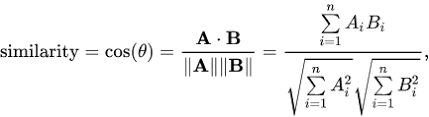

Because we have employed the TF-IDF vectorizer, calculating the dot product will result in the immediate delivery of the cosine similarity score to us. Because of this, we will utilise sklearn's linear kernel() rather than cosine similarities() given that it is a more efficient option.

In [143]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
movie_cosine_sim = linear_kernel(vector_tfidf_matrix, vector_tfidf_matrix)

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [144]:
#Create a map in reverse order using the indices and movie titles.
movie_indices = pd.Series(netflix_data.index, index=netflix_data['title']).drop_duplicates()
movie_indices

title
White Chicks                 0
Grey's Anatomy               2
Prison Break                 3
How I Met Your Mother        4
Supernatural                 5
                          ... 
The Magic School Bus       984
PokÃ©mon: Indigo League    986
Paddington                 988
Dawn of the Croods         991
The BFG                    995
Length: 574, dtype: int64

Our recommendation function can be defined in a reasonable manner at this point in time. The following are the stages that we will continue to follow:
* Obtain the index of the movie based on the title of the film.
* You should get a list of the cosine similarity scores comparing that one movie to all of the other movies. Convert it into a list of tuples, where the first element is its location and the second element represents the similarity score.
* Put the tuples in the aforementioned list in order according to their similarity scores, which is the second component.
* Take note of the most important ten items on this list. Ignore the first factor because it relates to you (self) (the movie most similar to a particular movie is the movie itself).
* It would be helpful if you could return the titles that correspond to the indices of the top items.

In [145]:
# Function that takes in movie title as input and outputs most similar movies
def get_Movie_recommendations(movie_title, movie_cosine_sim=movie_cosine_sim,movie_indices=movie_indices):
#Get the pairwise similarity scores of all movies that are related to that movie. # Get the index of the movie whose title matches what you are looking for. #
    mov_idx = movie_indices[movie_title]

# Arrange the films in descending order of their similarity ratings
    mov_sim_scores = list(enumerate(movie_cosine_sim[mov_idx]))

# Find out how each of the 10 films that are most like each other fared.
    #mov_sim_scores = sorted(mov_sim_scores, key=lambda x: x[1], reverse=True)

# Obtain the indices for the movie
    mov_sim_scores = mov_sim_scores[1:11]

# Return the top 10 movies that are most comparable to each other.
    movie_indices = [i[0] for i in mov_sim_scores]

    
    return netflix_data['title'].iloc[movie_indices]

In [146]:
get_Movie_recommendations('Prison Break')

2           Grey's Anatomy
3             Prison Break
4    How I Met Your Mother
5             Supernatural
6             Breaking Bad
7      The Vampire Diaries
Name: title, dtype: object

In [147]:
le = LabelEncoder()
netflix_data['rating'] = le.fit_transform(netflix_data['rating'])
netflix_data['ratingLevel'] = le.fit_transform(netflix_data['ratingLevel'])

In [148]:
Title=netflix_data.pop('title')
Y=netflix_data.pop('class')
X=netflix_data


In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

# Support Vector Machine

In [150]:
classifier1 = SVC(kernel='linear', random_state=0)  
classifier1.fit(X_train, y_train)  
y_pred=classifier1.predict(X_test)

<AxesSubplot:>

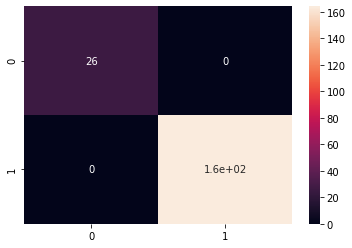

In [151]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)

In [152]:

print('Support Vector Machine')
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}") 
print(f"Precision: {round(precision_score(y_test, y_pred), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred), 2)}")
print(f"F1_score: {round(f1_score(y_test, y_pred), 2)}")

Support Vector Machine
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1_score: 1.0


# Random Forest

In [153]:
model = RandomForestClassifier()
model.fit(X_train, y_train)  
y_pred1=model.predict(X_test)

<AxesSubplot:>

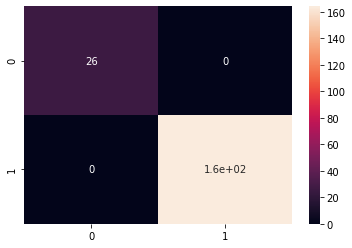

In [154]:
sns.heatmap(confusion_matrix(y_test, y_pred1), annot = True)

In [155]:
print('Random Forest')
print(f"Accuracy: {round(accuracy_score(y_test, y_pred1), 2)}") 
print(f"Precision: {round(precision_score(y_test, y_pred1), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred1), 2)}")
print(f"F1_score: {round(f1_score(y_test, y_pred1), 2)}")

Random Forest
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1_score: 1.0


# Naive Bayes

In [156]:

classifier3 = GaussianNB()
classifier3.fit(X_train, y_train)
y_pred2  =  classifier3.predict(X_test)

<AxesSubplot:>

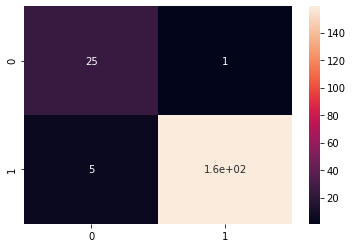

In [157]:
sns.heatmap(confusion_matrix(y_test, y_pred2), annot = True)

In [158]:
print('Naive Bayes')
print(f"Accuracy: {round(accuracy_score(y_test, y_pred2), 2)}") 
print(f"Precision: {round(precision_score(y_test, y_pred2), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred2), 2)}")
print(f"F1_score: {round(f1_score(y_test, y_pred2), 2)}")

Random Forest
Accuracy: 0.97
Precision: 0.83
Recall: 0.96
F1_score: 0.89


# Logistic Regression

In [162]:

classifier5 = LogisticRegression(random_state = 0)
classifier5.fit(X_train, y_train)
y_pred3 = classifier5.predict(X_test)

C:\Users\crssa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<AxesSubplot:>

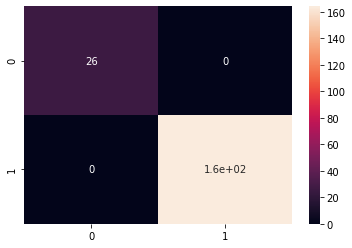

In [163]:

sns.heatmap(confusion_matrix(y_test, y_pred3), annot = True)

In [164]:

print('Logistic Regression')
print(f"Accuracy: {round(accuracy_score(y_test, y_pred3), 2)}") 
print(f"Precision: {round(precision_score(y_test, y_pred3), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred3), 2)}")
print(f"F1_score: {round(f1_score(y_test, y_pred3), 2)}")

Logistic Regression
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1_score: 1.0
